In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm
from gensim.models import Word2Vec, FastText
import gensim.downloader as api
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 🛠 Downloads
nltk.download('punkt')
nltk.download('stopwords')
tqdm.pandas()

# Load Dataset
df = pd.read_csv(r'C:\Users\acer\Desktop\SNLP\SNLP_Assignments_Sem7_J065\Assignment 1\IMDB Dataset.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sample Data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


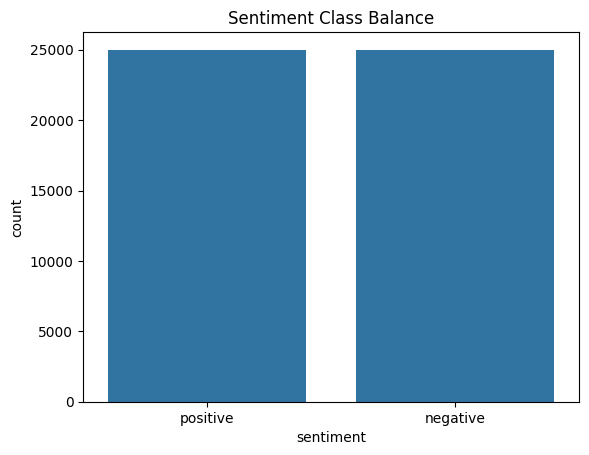

In [2]:
#  Basic Info
print("Sample Data:")
print(df.head())

#  Class Balance
print("\nClass Distribution:")
print(df['sentiment'].value_counts())

#  Plot Distribution
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Class Balance")
plt.show()

In [3]:
# Clean Text Function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # Remove HTML
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-letters
    tokens = word_tokenize(text.lower())  # Tokenize + Lower
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

#  Apply Cleaning
df['tokens'] = df['review'].progress_apply(clean_text)
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

100%|██████████| 50000/50000 [00:32<00:00, 1552.15it/s]


In [4]:
# Convert list of tokens to average vector
def get_avg_vector(tokens, model, dim):
    vec = np.zeros(dim)
    count = 0
    for token in tokens:
        if token in model:
            vec += model[token]
            count += 1
    return vec / count if count != 0 else vec

# Classifier trainer
def train_model(X, y, label=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n📊 {label} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    return acc

In [5]:
# Load Pretrained W2V (Google News)
print("\n🔁 Loading Pretrained Word2Vec (Google News)...")
w2v_model = api.load('word2vec-google-news-300')

# Vector Representation
X_w2v = np.array([get_avg_vector(tokens, w2v_model, 300) for tokens in tqdm(df['tokens'])])

# Train Model
acc_w2v = train_model(X_w2v, df['label'].values, "Pretrained Word2Vec")


🔁 Loading Pretrained Word2Vec (Google News)...
[==================================================] 100.0% 1662.8/1662.8MB downloaded


100%|██████████| 50000/50000 [00:17<00:00, 2917.38it/s]



📊 Pretrained Word2Vec Accuracy: 0.8491
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [6]:
# Train Skip-gram Model
print("\n🔁 Training Custom Skip-gram...")
skipgram_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, sg=1, min_count=2, workers=4)

# Vector Representation
X_sg = np.array([get_avg_vector(tokens, skipgram_model.wv, 100) for tokens in tqdm(df['tokens'])])

# Train Model
acc_sg = train_model(X_sg, df['label'].values, "Custom Skip-gram")


🔁 Training Custom Skip-gram...


100%|██████████| 50000/50000 [00:15<00:00, 3269.42it/s]



📊 Custom Skip-gram Accuracy: 0.8778
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4961
           1       0.88      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [7]:
# Train CBOW Model
print("\n🔁 Training Custom CBOW...")
cbow_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, sg=0, min_count=2, workers=4)

# Vector Representation
X_cbow = np.array([get_avg_vector(tokens, cbow_model.wv, 100) for tokens in tqdm(df['tokens'])])

# Train Model
acc_cbow = train_model(X_cbow, df['label'].values, "Custom CBOW")


🔁 Training Custom CBOW...


100%|██████████| 50000/50000 [00:15<00:00, 3247.39it/s]



📊 Custom CBOW Accuracy: 0.8627
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4961
           1       0.86      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [8]:
# Train FastText Model
print("\n🔁 Training Custom FastText...")
fasttext_model = FastText(sentences=df['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Vector Representation
X_ft = np.array([get_avg_vector(tokens, fasttext_model.wv, 100) for tokens in tqdm(df['tokens'])])

# Train Model
acc_ft = train_model(X_ft, df['label'].values, "Custom FastText")


🔁 Training Custom FastText...


100%|██████████| 50000/50000 [00:17<00:00, 2867.40it/s]



📊 Custom FastText Accuracy: 0.8530
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4961
           1       0.85      0.86      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [9]:
# Tabulate All Results
results = pd.DataFrame({
    "Model": ["Pretrained Word2Vec", "Custom Skip-gram", "Custom CBOW", "Custom FastText"],
    "Accuracy": [acc_w2v, acc_sg, acc_cbow, acc_ft]
})

print("\n📋 Model Accuracy Comparison:")
print(results)


📋 Model Accuracy Comparison:
                 Model  Accuracy
0  Pretrained Word2Vec    0.8491
1     Custom Skip-gram    0.8778
2          Custom CBOW    0.8627
3      Custom FastText    0.8530
